<a href="https://colab.research.google.com/github/AnyByte/iu5_bi_course/blob/master/lab2/task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа №2 по дисциплине «Инструменты бизнес-аналитики» 

## 2 задача.
### Условие
Шест прикреплен неработающим шарниром к тележке, которая движется по бесфрикционному пути. Маятник начинает двигаться вертикально, и цель состоит в том, чтобы предотвратить его падение, увеличивая и уменьшая скорость тележки.
### Вознаграждения
Вознаграждение составляет 1 за каждый сделанный шаг, включая шаг прекращения действия договора. Пороговое значение составляет 475 для v1.
### Решение
Считается решенным, когда среднее вознаграждение больше или равно 195,0 в течение 100 последовательных испытаний.

In [0]:
# !pip install --user git+https://github.com/google-research/tf-slim

In [0]:
import tensorflow.compat.v1 as tf
import tf_slim as slim
import numpy as np
import gym
import matplotlib.pyplot as plt
%matplotlib inline

tf.disable_v2_behavior()

try:
    xrange = xrange
except:
    xrange = range

env = gym.make('CartPole-v0') #загружаем среду задачи

In [0]:
gamma = 0.99 # коэффициент дисконтирования
 
def discount_rewards(r):
    """ принимая на вход вектор выигришей, 
    вернуть вектор дисконтированных выигрышей"""
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(xrange(0, r.size)):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

In [0]:
class agent():
    def __init__(self, lr, s_size,a_size,h_size):
        #Ниже инициализирована feed-forward часть нейросети. 
        #Агент оценивает состояние среды и совершает действие
        self.state_in= tf.placeholder(shape=[None,s_size],dtype=tf.float32)
        hidden = slim.fully_connected(self.state_in,h_size,
                      biases_initializer=None,activation_fn=tf.nn.relu)
        self.output = slim.fully_connected(hidden,a_size,
                      activation_fn=tf.nn.softmax,biases_initializer=None)
        self.chosen_action = tf.argmax(self.output,1) # выбор действия

        #Следующие 6 строк устанавливают процедуру обучения. 
        #Нейросеть принимает на вход выбранное действие
        # и соответствующий выигрыш,
        #чтобы оценить функцию потерь и обновить веса модели.
        self.reward_holder = tf.placeholder(shape=[None],dtype=tf.float32)
        self.action_holder = tf.placeholder(shape=[None],dtype=tf.int32)
        
        self.indexes = tf.range(0, 
        tf.shape(self.output)[0])*tf.shape(self.output)[1] + self.action_holder

        self.responsible_outputs = tf.gather(tf.reshape(self.output, [-1]), 
        self.indexes)
        #функция потерь
        self.loss = -tf.reduce_mean(tf.log(self.responsible_outputs)*
        self.reward_holder) 
        
        tvars = tf.trainable_variables()
        self.gradient_holders = []
        for idx,var in enumerate(tvars):
            placeholder = tf.placeholder(tf.float32,name=str(idx)+'_holder')
            self.gradient_holders.append(placeholder)
        
        self.gradients = tf.gradients(self.loss,tvars)
        
        optimizer = tf.train.AdamOptimizer(learning_rate=lr) 
        self.update_batch = optimizer.apply_gradients(zip(self.gradient_holders,
        tvars))

Episode: 0 Reward: 22.0
Episode: 100 Reward: 32.31
Episode: 200 Reward: 35.87
Episode: 300 Reward: 40.25
Episode: 400 Reward: 51.26
Episode: 500 Reward: 52.71
Episode: 600 Reward: 62.43
Episode: 700 Reward: 61.56
Episode: 800 Reward: 74.75
Episode: 900 Reward: 127.17
Episode: 1000 Reward: 164.11
Episode: 1100 Reward: 165.52
Episode: 1200 Reward: 175.12
Episode: 1300 Reward: 169.81
Episode: 1400 Reward: 185.23
Episode: 1500 Reward: 188.6
Episode: 1600 Reward: 161.46
Episode: 1700 Reward: 193.07
Целевое значение достигнуто (Reward: 198.48).


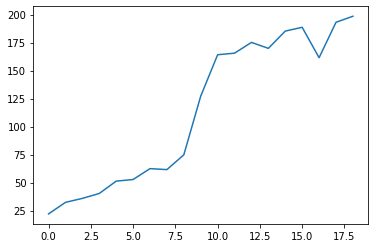

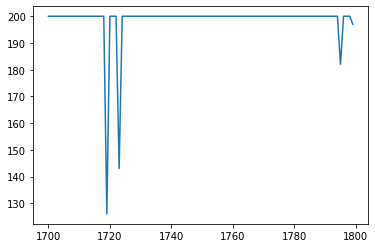

In [125]:
tf.reset_default_graph() #Очищаем граф tensorflow

myAgent = agent(lr=1e-2,s_size=4,a_size=2,h_size=8) #Инициализируем агента

total_episodes = 5000 #Количество итераций обучения
max_ep = 999
update_frequency = 5

init = tf.global_variables_initializer()

#Запуск графа tensorflow
with tf.Session() as sess:
    sess.run(init)
    i = 0
    total_reward = []
    total_lenght = []
    graph_points = []
        
    gradBuffer = sess.run(tf.trainable_variables())
    for ix,grad in enumerate(gradBuffer):
        gradBuffer[ix] = grad * 0
        
    while i < total_episodes:
        s = env.reset()
        running_reward = 0
        ep_history = []
        for j in range(max_ep):
            #Выбрать действие на основе вероятностей, оцененных нейросетью
            a_dist = sess.run(myAgent.output,feed_dict={myAgent.state_in:[s]})
            a = np.random.choice(a_dist[0],p=a_dist[0])
            a = np.argmax(a_dist == a)

            s1,r,d,_ = env.step(a) #Получить награду за совершенное действие
            ep_history.append([s,a,r,s1])
            s = s1
            running_reward += r
            if d == True:
                #Обновить нейросеть
                ep_history = np.array(ep_history)
                ep_history[:,2] = discount_rewards(ep_history[:,2])
                feed_dict = {myAgent.reward_holder:ep_history[:,2],
                             myAgent.action_holder:ep_history[:,1],
                             myAgent.state_in:np.vstack(ep_history[:,0])}
                grads = sess.run(myAgent.gradients, feed_dict=feed_dict)
                for idx,grad in enumerate(grads):
                    gradBuffer[idx] += grad

                if i % update_frequency == 0 and i != 0:
                    feed_dict = dictionary = dict(zip(myAgent.gradient_holders, 
                                     gradBuffer))
                    _ = sess.run(myAgent.update_batch, feed_dict=feed_dict)
                    for ix,grad in enumerate(gradBuffer):
                        gradBuffer[ix] = grad * 0
                
                total_reward.append(running_reward)
                total_lenght.append(j)
                break

        
            #Обновить общий выигрыш
        if i % 100 == 0:
            graph_points.append(np.mean(total_reward[-100:]))
            if np.mean(total_reward[-100:]) >= 195.0:

                x = range(len(graph_points))
                y = graph_points

                fig = plt.figure()
                ax = fig.add_subplot(1, 1, 1)
                ax.plot(x, y)

                from_idx = len(total_reward) - 101
                to_idx = len(total_reward) - 1

                x = range(from_idx, to_idx)
                y = total_reward[from_idx:to_idx]
                fig = plt.figure()
                ax = fig.add_subplot(1, 1, 1)
                ax.plot(x, y)

                print(f"Целевое значение достигнуто (Reward: {np.mean(total_reward[-100:])}).")
                break
            else:
                print(f"Episode: {i} Reward: {np.mean(total_reward[-100:])}")
        i += 1

# Вывод
Результаты соответствуют решению задачи, а изменение параметров модели ведёт к ухудшению результатов, поэтому было решено оставить параметры в исходном виде.